## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
5037447,295434,7829,128,210,3.0
3982637,641883,12173,36,3872,37.0
4302293,778739,3518,63,7241,100.0
255276,731846,10440,149,14909,70.0
78280,169083,15084,147,3477,12.0


Сделаем разбиение по времени

<Axes: >

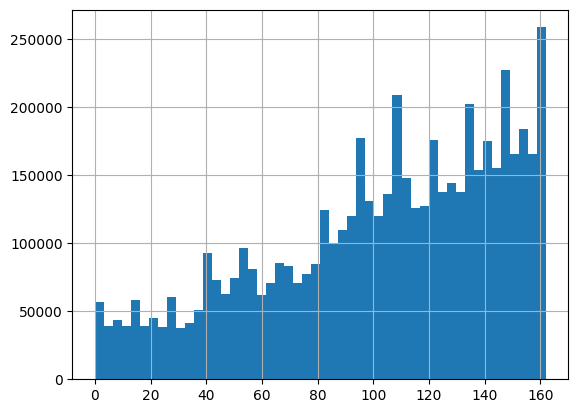

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
27,841859,3935,94,8862,100.0
95,858651,15998,110,63,9.0
150,179618,9988,121,6811,100.0
160,59968,3734,146,9445,100.0
183,339681,13865,92,6460,100.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/var/folders/34/9lmn_1px5cs289tjl5rn7cs80000gn/T/ipykernel_30169/1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/var/folders/34/9lmn_1px5cs289tjl5rn7cs80000gn/T/ipykernel_30169/1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,259,"[(13865, 109), (10440, 110), (9194, 110), (144..."
1,299,"[(1154, 1), (3208, 40), (12671, 40), (16390, 4..."
2,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8..."
3,317,"[(4495, 130)]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,259,"[(13865, 109), (10440, 110), (9194, 110), (144...","[(10772, 153), (10770, 153), (1769, 158), (458..."
1,299,"[(1154, 1), (3208, 40), (12671, 40), (16390, 4...","[(10440, 153)]"
2,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]"
3,317,"[(4495, 130)]","[(16166, 154)]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]"


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,259,"[(13865, 109), (10440, 110), (9194, 110), (144...","[(10772, 153), (10770, 153), (1769, 158), (458...","[8489, 42, 4857]"
1,299,"[(1154, 1), (3208, 40), (12671, 40), (16390, 4...","[(10440, 153)]","[8489, 42, 4857]"
2,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[8489, 42, 4857]"
3,317,"[(4495, 130)]","[(16166, 154)]","[8489, 42, 4857]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8489, 42, 4857]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [12]:
import numpy as np
from typing import List, Optional

def ap_metric(gt_items: List[int],
              predictions: List[int],
              topn: Optional[int]=None):

    if topn is None:
        topn = len(predictions)

    preds = np.array(predictions[:topn])
    relevances = np.isin(preds, gt_items).astype(int)
    precision_at_i = np.cumsum(relevances) / (np.arange(1, topn + 1))
    ap = np.sum(precision_at_i * relevances) / min(topn, len(gt_items))

    return ap


def rr_metric(gt_items: List[int],
              predictions: List[int],
              topn: Optional[int]=None):
    
    if topn is None:
        topn = len(predictions)
    
    preds = np.array(predictions[:topn])
    relevances = np.isin(preds, gt_items).astype(int)
    first_hit = np.argmax(relevances) + 1 if np.any(relevances) else 0

    return 1 / first_hit if first_hit else 0


def hr_metric(gt_items: List[int],
              predictions: List[int],
              topn: Optional[int]=None):
    
    if topn is None:
        topn = len(predictions)
    
    preds = np.array(predictions[:topn])
    
    return int(np.any(np.isin(preds, gt_items)))

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [13]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [14]:
import numpy as np
import pandas as pd

def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    gt_items_list = df[gt_col].apply(lambda x: [item[0] for item in x]).to_numpy()
    preds_list = df[model_preds].to_numpy()

    aps = np.array([ap_metric(gt, preds) for gt, preds in zip(gt_items_list, preds_list)])
    rrs = np.array([rr_metric(gt, preds) for gt, preds in zip(gt_items_list, preds_list)])
    hrs = np.array([hr_metric(gt, preds) for gt, preds in zip(gt_items_list, preds_list)])

    return {
        'map': np.mean(aps),
        'mrr': np.mean(rrs),
        'hr': np.mean(hrs)
    }

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.00022222222222222223, 'mrr': 0.0006666666666666666, 'hr': 0.0008}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [16]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,259,"[(13865, 109), (10440, 110), (9194, 110), (144...","[(10772, 153), (10770, 153), (1769, 158), (458...","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
1,299,"[(1154, 1), (3208, 40), (12671, 40), (16390, 4...","[(10440, 153)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
2,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
3,317,"[(4495, 130)]","[(16166, 154)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06442729013920381, 'mrr': 0.11553551587301587, 'hr': 0.2653}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
import numpy as np
import pandas as pd

class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, window in row[col]:
                if  window >= 160 - 7 - self.min_window :
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


time_window = 30
toppop_weighted = TopPopularWeighted(time_window)
toppop_weighted.fit(joined)

joined['toppopular_weighted_recs'] = toppop_weighted.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_weighted_recs
0,259,"[(13865, 109), (10440, 110), (9194, 110), (144...","[(10772, 153), (10770, 153), (1769, 158), (458...","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,..."
1,299,"[(1154, 1), (3208, 40), (12671, 40), (16390, 4...","[(10440, 153)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,..."
2,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,..."
3,317,"[(4495, 130)]","[(16166, 154)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,..."


Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [19]:
def graph_metrics(k, k_name, map_values, mrr_values, hr_values):

    plt.figure(figsize=(18, 5))

    # MAP
    plt.subplot(1, 3, 1)
    plt.plot(k, map_values, label='MAP@10', marker='o', color='blue')
    plt.xlabel(k_name)
    plt.ylabel('MAP@10')
    plt.title(f'MAP@10 и {k_name}')
    plt.legend()
    plt.grid()

    # MRR
    plt.subplot(1, 3, 2)
    plt.plot(k, mrr_values, label='MRR@10', marker='s', color='green')
    plt.xlabel(k_name)
    plt.ylabel('MRR@10')
    plt.title(f'MRR@10 и {k_name}')
    plt.legend()
    plt.grid()

    # HR
    plt.subplot(1, 3, 3)
    plt.plot(k, hr_values, label='HR@10', marker='^', color='red')
    plt.xlabel(k_name)
    plt.ylabel('HR@10')
    plt.title(f'HR@10 и {k_name}')
    plt.legend()
    plt.grid()

    plt.show()

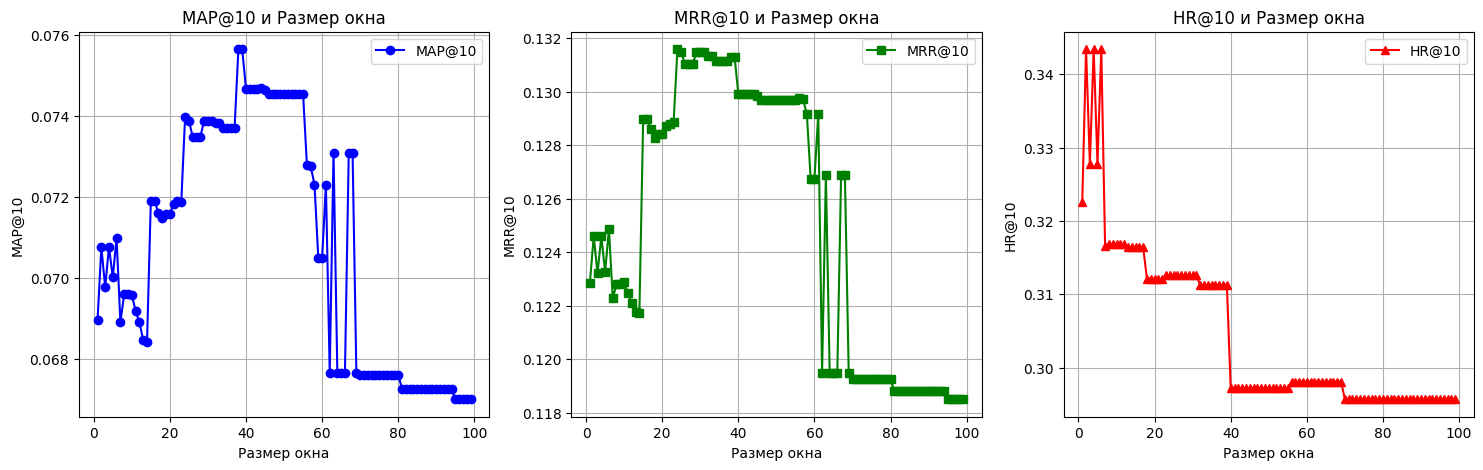

In [20]:
# your code here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Размер окна, который будем тестировать
window_sizes = list(range(1, 100))

# Списки для хранения значений метрик
map_values, mrr_values, hr_values = [], [], []
df_metrics = joined[["user_id", "train_interactions", "test_interactions"]].copy()

# Проходим по разным размерам окна
for window in window_sizes:
    toppop_weighted = TopPopularWeighted(min_window=window)
    toppop_weighted.fit(joined)

    df_metrics['toppopular_recs'] = toppop_weighted.predict(joined, topn=10)
    metrics = evaluate_recommender(df_metrics, 'toppopular_recs')

    # Сохраняем результаты
    map_values.append(metrics['map'])
    mrr_values.append(metrics['mrr'])
    hr_values.append(metrics['hr'])

# Строим графики
graph_metrics(window_sizes, "Размер окна", map_values, mrr_values, hr_values)

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**  
Увеличение размера окна с 1 до 18 дней приводит к некоторому снижению метрик, что видимо обусловлено выходом новинок, которые являются не столько популярными, сколько новыми и модель предлагает их.  
Дальнейшее увеличение размера окна с 19 до 56 дней (8 недель) ведет к росту качества рекомендаций (метрики MAP и MRR), что является следствием попадания в рекомендации популярных в последнее время фильмов.  
Далее, увеличение приводит к снижению качества рекомендаций. Основная причина по моему мнению заключается в том, что мы начинаем рекомендовать пользователям фильмы, утратившие на текущий момент популярность.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [21]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.07450070870322341, 'mrr': 0.1272295404211882, 'hr': 0.5576}

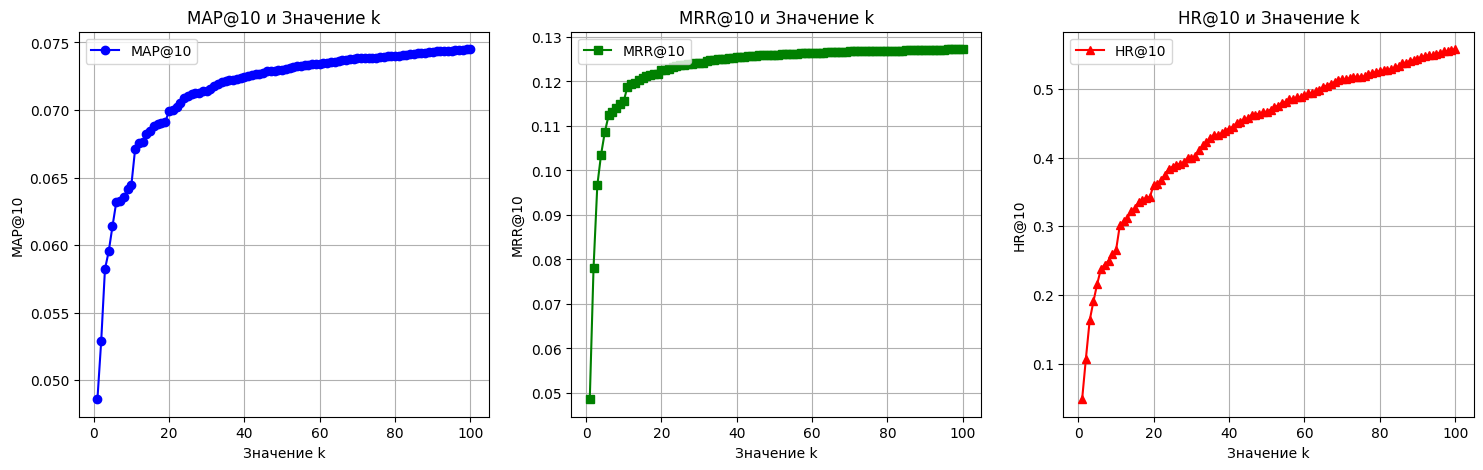

In [22]:
# your code here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Размер окна, который будем тестировать
k_values = list(range(1, 101))

# Списки для хранения значений метрик
map_values, mrr_values, hr_values = [], [], []
df_metrics = joined[["user_id", "train_interactions", "test_interactions"]].copy()

# Проходим по разным размерам окна
for k in k_values:
    toppop_weighted = TopPopular()
    toppop_weighted.fit(joined)

    df_metrics['toppopular_recs'] = toppop_weighted.predict(joined, topn=k)
    metrics = evaluate_recommender(df_metrics, 'toppopular_recs')

    # Сохраняем результаты
    map_values.append(metrics['map'])
    mrr_values.append(metrics['mrr'])
    hr_values.append(metrics['hr'])

# Строим графики
graph_metrics(k_values, "Значение k", map_values, mrr_values, hr_values)

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**  
Метрики MRR и HR являются монотонно неубывающими по k. Это связано с тем, что с увеличением k метрики пользователей либо остаются прежними(в случае, если оценки по указанным метрикам отличаются от 0), либо увеличиваются (с 0 на 1 для HR и с 0 на 1/k для MRR).  
Метрика MAP не является монотонной, так как в случае, когда новые предсказания нерелевантны, метрика снижается. Однако метрика MAP проявляет тенденцию к росту при увеличении k с выходом на некоторое плато.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей.
**Ответ:**  
Более быстрый рост метрик MAP и MRR (относительно максимального значения) свидетельствует о том, что вверху списка (ленты новостей) располагаются более релевантные объекты. Таким образом пользователь будет находить больше интересных для себя объектов вверху ленты. Постепенный и достаточно стабильный рост HR говорит о том, что чем больше предложений от рекомендательной системы приходит, тем больше шанс листая ленту найти интересующий пользователя объект.  
Метрики показывают, что при скроллинге ленты новостей пользователь будет находить все меньше релевантных объектов.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**  
MAP и MRR - растут и выходят на некоторое плато, что отражает сам факт ранжирования предложений (вначале релевантных объектов больше). MAP со временем может немного снижаться.
метрика RR растет также с некоторым замедлением, но также выйдет на плато, когда для большинства (возможно для всех пользователей) будет рекомендован как минимум 1 релевантный объект


**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [23]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

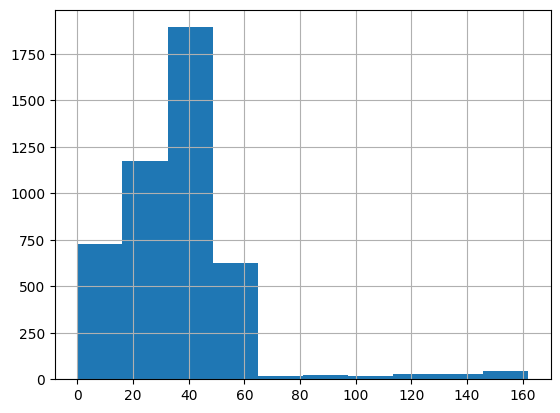

In [24]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

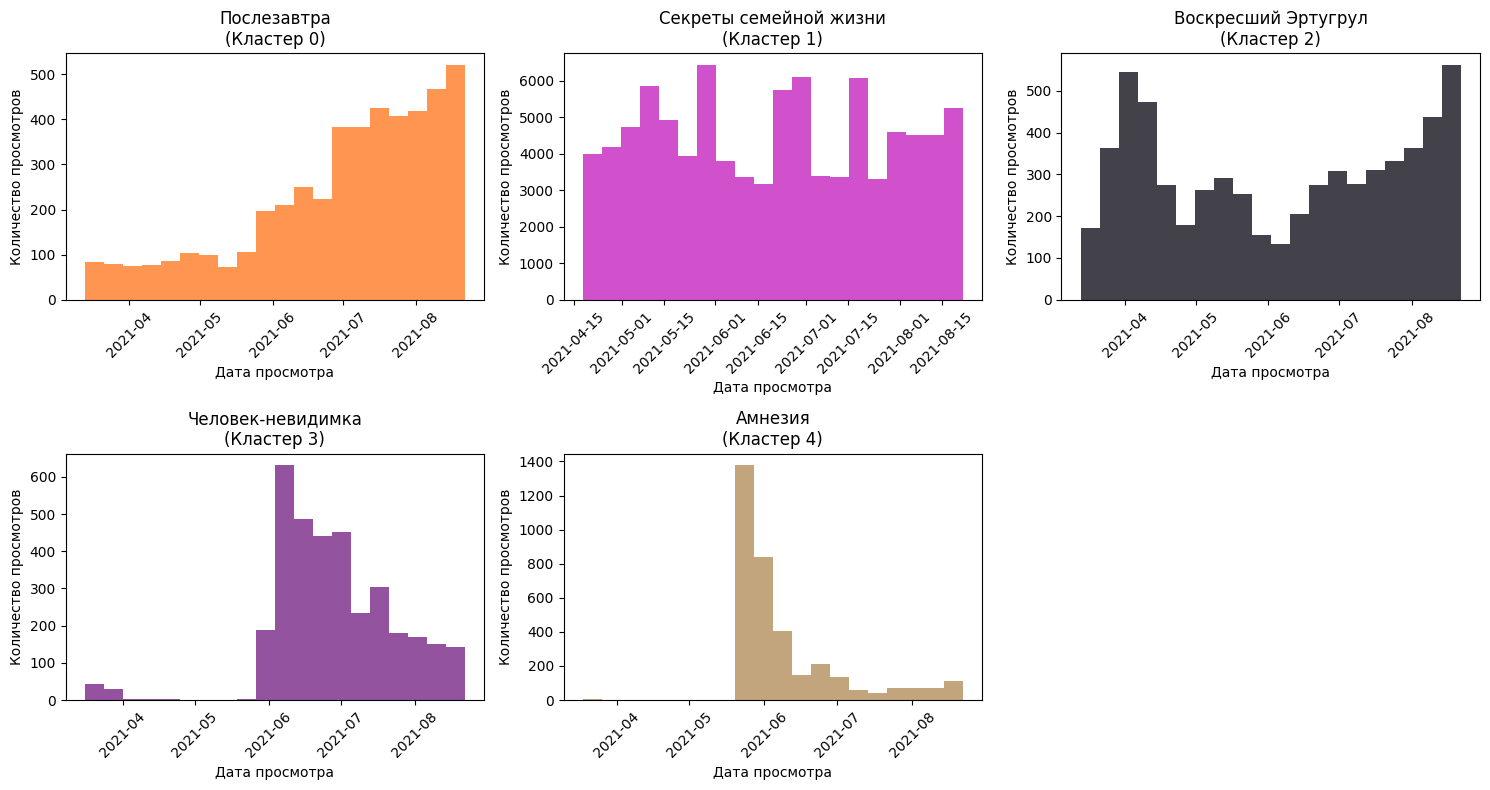

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Загружаем данные
df_cluster = pd.read_csv('interactions.csv')
items = pd.read_csv('items.csv')

# Преобразуем столбец с датами в формат datetime
df_cluster['last_watch_dt'] = pd.to_datetime(df_cluster['last_watch_dt'])

# Определяем топ-300 популярных фильмов по количеству взаимодействий
popular_items = df_cluster['item_id'].value_counts().index[:300]

# Оставляем только эти фильмы в датафрейме
df_top = df_cluster[df_cluster['item_id'].isin(popular_items)].copy()

# Функция для безопасного вычисления моды
def safe_mode(series):
    try:
        return mode(series, nan_policy='omit').mode[0]
    except IndexError:
        return np.nan

# Группируем данные по фильмам и считаем статистики
popularity_grouped = df_top.groupby('item_id').agg(
    mean_popularity=('user_id', 'count'),
    var_popularity=('user_id', 'var'),
    median_popularity=('user_id', 'median'),
    mode_popularity=('user_id', safe_mode)
).fillna(0)

# Нормализация данных перед кластеризацией
scaler = StandardScaler()
popularity_scaled = scaler.fit_transform(popularity_grouped)

# Кластеризация фильмов (5 кластеров)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
popularity_grouped['cluster'] = kmeans.fit_predict(popularity_scaled)

# Интерпретация кластеров
clusters = {}
for i in range(5):
    sample_movies = popularity_grouped[popularity_grouped['cluster'] == i].index[:5].tolist()
    clusters[f'Кластер {i}'] = sample_movies

# Визуализация активности просмотров фильмов по кластерам
plt.figure(figsize=(15, 8))

for i, (cluster_name, item_ids) in enumerate(clusters.items(), 1):
    sampled_id = item_ids[2]
    interactions = df.loc[df['item_id'] == sampled_id].copy()

    # Проверяем, есть ли название фильма
    title_row = items.loc[items['item_id'] == sampled_id, 'title']
    name = title_row.values[0] if not title_row.empty else f"ID {sampled_id}"

    plt.subplot(2, 3, i)
    plt.hist(interactions['last_watch_dt'].sort_values(), bins=20, alpha=0.75, color=np.random.rand(3,))
    
    plt.title(f"{name}\n({cluster_name})", fontsize=12)
    plt.xlabel('Дата просмотра')
    plt.ylabel('Количество просмотров')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Поиск фильмов был осуществлен с использованием кластеризации по основным статистическим параметрам распределения количества просмотров. Было выделено 5 кластеров:
Кластер 0 (Послезавтра): Постепенный рост популярности фильма  
Кластер 1 (Секреты семейной жизни): стабильное количество просмотров  
Кластер 2 (Воскресший Эртугрул): Два пика популярности - в начале и в конце периода  
Кластер 3 (Невидимка): Резкий рост популярности с постепенным снижением  
Кластер 4 (Амнезия): Резкий рост популярности со значительным от начального уровня снижением с выходом на плато

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [26]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    # your code here
    counts = df[col].value_counts()
    valid_values = counts[counts >= min_freq].index

    return df[df[col].isin(valid_values)]

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    # your code here
    while True:
        initial_shape = df.shape  # Запоминаем размер до фильтрации
        
        # Фильтруем по пользователям
        df = filter_column(df, cols[0], min_freq)
        # Фильтруем по айтемам
        df = filter_column(df, cols[1], min_freq)

        # Если размер не изменился, значит сходимость достигнута
        if df.shape == initial_shape:
            break

    return df

filtered_train = filter_dataframe(train_df, ('user_id', 'item_id'), min_freq=5)

In [27]:
filtered_train

,user_id,item_id,last_watch_dt,total_dur,watched_pct
27,841859,3935,94,8862,100.0
95,858651,15998,110,63,9.0
150,179618,9988,121,6811,100.0
183,339681,13865,92,6460,100.0
230,500077,3819,130,961,8.0
...,...,...,...,...,...
5475960,214741,9617,140,3247,39.0
5476077,796541,4403,29,155,3.0
5476092,280117,14431,3,377,7.0
5476213,706423,3384,0,5937,100.0


In [28]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}  # Исправлено

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, user2id, item2id, id2user, id2item

filtered_train, user2id, item2id, id2user, id2item = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
607415,4310,216,93,3458,66.0
4479917,454,1961,131,8862,100.0
2937170,4308,941,43,621,10.0
2895720,4165,1179,152,702,15.0
746137,4671,5,98,8179,100.0


In [29]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 104941 stored elements and shape (5863, 3046)>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [30]:
filtered_train = filter_dataframe(train_df, ('user_id', 'item_id'), min_freq=5)

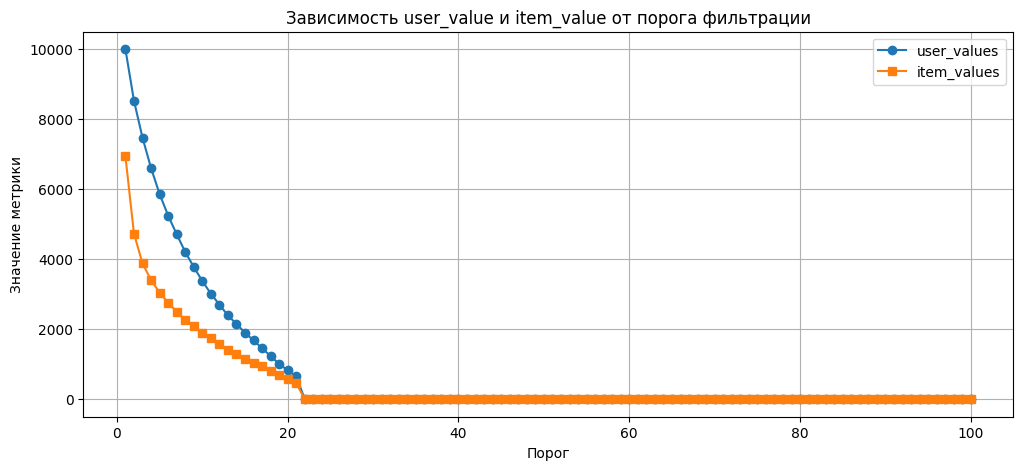

In [31]:
# your code here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Размер порога
min_freqs = list(range(1, 101))

# Списки для хранения значений метрик
user_values, item_values = [], []

# Проходим по разным порогам
for min_freq in min_freqs:
    filtered_train = filter_dataframe(train_df, ('user_id', 'item_id'), min_freq=min_freq)

    # Сохраняем результаты
    user_values.append(len(filtered_train['user_id'].unique()))
    item_values.append(len(filtered_train['item_id'].unique()))

# Строим графики
plt.figure(figsize=(12, 5))

plt.plot(min_freqs, user_values, label='user_values', marker='o')
plt.plot(min_freqs, item_values, label='item_values', marker='s')

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Зависимость user_value и item_value от порога фильтрации')
plt.legend()
plt.grid()
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [32]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
# 
def fit_ease(X, reg_weight=1000):
    
 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: user 4.35 s, sys: 173 ms, total: 4.52 s
Wall time: 809 ms


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [33]:
def get_preds(x, item2id, id2item, top_k=100):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:top_k]
    
    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_weighted_recs,ease_preds
0,259,"[(13865, 109), (10440, 110), (9194, 110), (144...","[(10772, 153), (10770, 153), (1769, 158), (458...","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,...","[10440, 13865, 9728, 15297, 4151, 3734, 8636, ..."
1,299,"[(1154, 1), (3208, 40), (12671, 40), (16390, 4...","[(10440, 153)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,...","[10440, 15297, 4151, 3734, 9728, 142, 13865, 4..."
2,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,...","[15297, 10440, 13865, 4151, 9728, 142, 4880, 2..."
3,317,"[(4495, 130)]","[(16166, 154)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,...","[13865, 9728, 9996, 10440, 3734, 7829, 12995, ..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8489, 42, 4857]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[9728, 15297, 10440, 13865, 3734, 4151, 12192,...","[13865, 4151, 15297, 10440, 9728, 142, 3734, 2..."


In [34]:
# your code here
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.07450070870322341, 'mrr': 0.1272295404211882, 'hr': 0.5576}

In [35]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.08532935672372816, 'mrr': 0.14948556933612575, 'hr': 0.5985}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**  
Лучшим является алгоритм EASE: он превосходит метод популярности по всем метрикам

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

best MAP@10: 0.0914, reg: 49238.8
best MRR@10: 0.1598, reg: 19144.8
best HR@10: 0.6067, reg: 5878.0


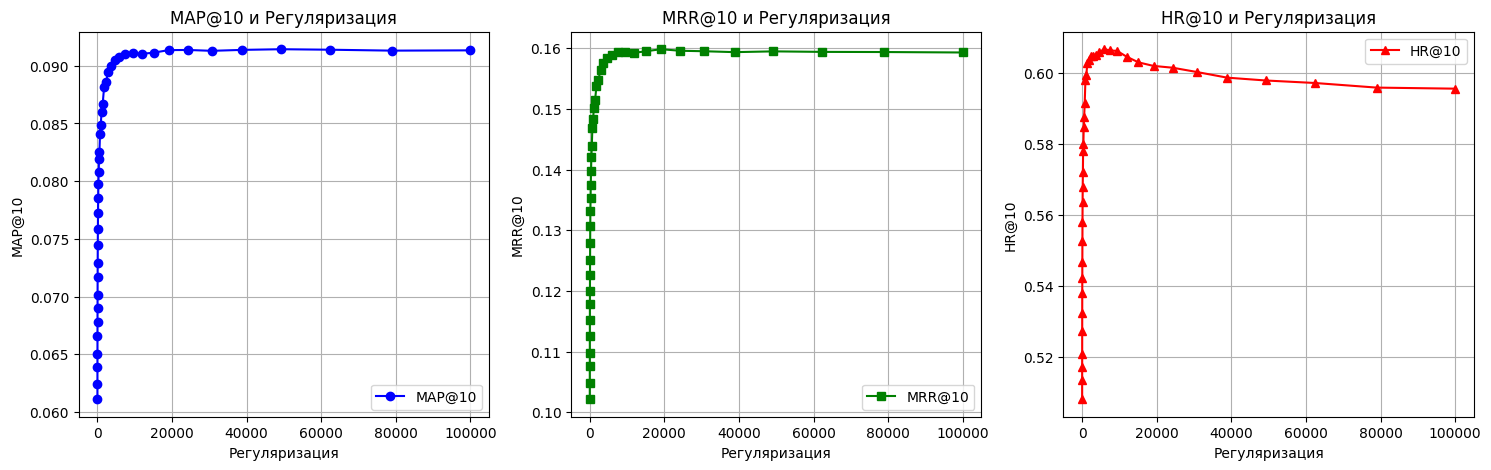

In [37]:
# your code here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Регуляризация
reg_weights = np.logspace(1, 5, num=40)

# Списки для хранения значений метрик
map_values, mrr_values, hr_values = [], [], []
df_easy = joined[["user_id", "train_interactions", "test_interactions"]].copy()

# Проходим по разным параметрам регуляризации
for reg in reg_weights:
    
    w = fit_ease(matrix, reg)
    df_easy['ease_preds'] = df_easy.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))

    metrics = evaluate_recommender(df_easy, 'ease_preds')

    # Сохраняем результаты
    map_values.append(metrics['map'])
    mrr_values.append(metrics['mrr'])
    hr_values.append(metrics['hr'])

# Выводим параметры и достигнутые лучшие значения
print(f'best MAP@10: {max(map_values):.4f}, reg: {reg_weights[map_values.index(max(map_values))]:.1f}')
print(f'best MRR@10: {max(mrr_values):.4f}, reg: {reg_weights[mrr_values.index(max(mrr_values))]:.1f}')
print(f'best HR@10: {max(hr_values):.4f}, reg: {reg_weights[hr_values.index(max(hr_values))]:.1f}')

# Строим графики
graph_metrics(reg_weights, 'Регуляризация', map_values, mrr_values, hr_values)

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:**  
Зависит от целей, но наиболее оптимальным видится 19144.8, для него метрики MAP@10 и MRR@10 достигают максимума.

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**  
Метрики MAP@10, MRR@10, быстро выходят на плато, однако, если увеличить параметр в 1000 раз, график их зависимости от парметра схож с HR@10 - также наблюдается некоторое снижение после достижения максимума
Метрика HR@10 быстро достигает максимума, после снижается к некоторому плато.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

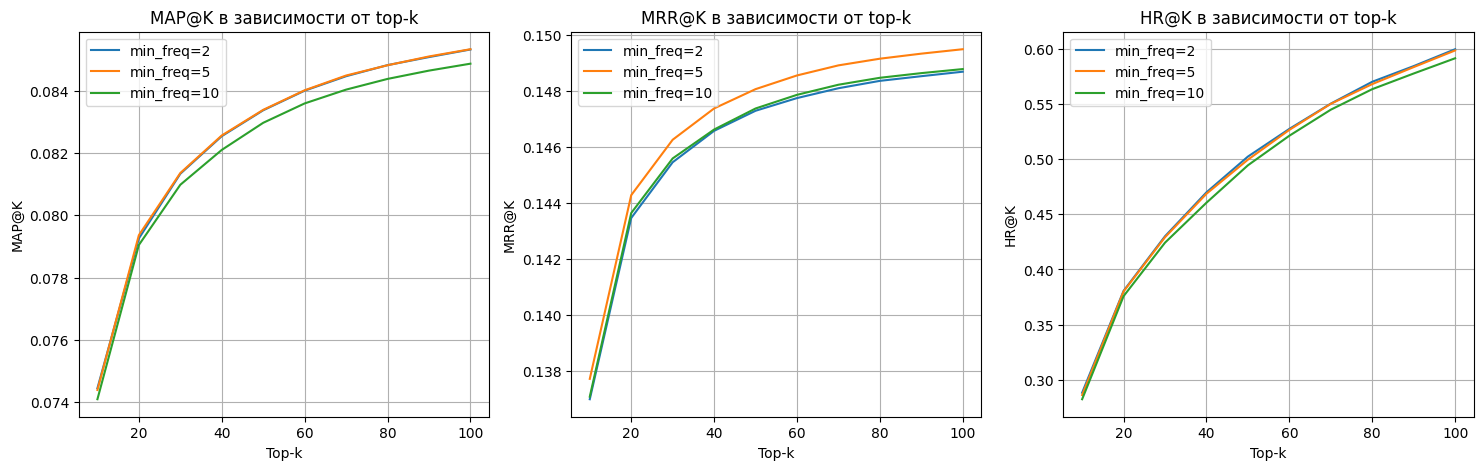

In [40]:
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt

# Гиперпараметры
min_freqs = [2, 5, 10]
top_ks = list(range(10, 102, 10))

# Словари для хранения метрик
map_scores = {}
mrr_scores = {}
hr_scores = {}

# Перебираем min_freq
for min_freq in min_freqs:

    filtered_train = filter_dataframe(train_df, ('user_id', 'item_id'), min_freq=min_freq)
    filtered_train, user2id, item2id, id2user, id2item = df_encode(filtered_train)

    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(len(user2id), len(item2id)),
    )

    w = fit_ease(matrix)

    # Делаем предсказания
    map_k, mrr_k, hr_k = [], [], []

    # Перебираем top-k
    for k in top_ks:

        joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, k))

        map_k.append(evaluate_recommender(joined, model_preds='ease_preds')['map'])
        mrr_k.append(evaluate_recommender(joined, model_preds='ease_preds')['mrr'])
        hr_k.append(evaluate_recommender(joined, model_preds='ease_preds')['hr'])

    map_scores[min_freq] = map_k
    mrr_scores[min_freq] = mrr_k
    hr_scores[min_freq] = hr_k

# Строим графики
plt.figure(figsize=(18, 5))

# MAP
plt.subplot(1, 3, 1)
for min_freq in min_freqs:
    plt.plot(top_ks, map_scores[min_freq], label=f"min_freq={min_freq}")
plt.xlabel("Top-k")
plt.ylabel("MAP@K")
plt.title("MAP@K в зависимости от top-k")
plt.legend()
plt.grid()

# MRR
plt.subplot(1, 3, 2)
for min_freq in min_freqs:
    plt.plot(top_ks, mrr_scores[min_freq], label=f"min_freq={min_freq}")
plt.xlabel("Top-k")
plt.ylabel("MRR@K")
plt.title("MRR@K в зависимости от top-k")
plt.legend()
plt.grid()

# HR
plt.subplot(1, 3, 3)
for min_freq in min_freqs:
    plt.plot(top_ks, hr_scores[min_freq], label=f"min_freq={min_freq}")
plt.xlabel("Top-k")
plt.ylabel("HR@K")
plt.title("HR@K в зависимости от top-k")
plt.legend()
plt.grid()

plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**  
Графики соответствуют предположению о том, что чем ниже порог встречаемости, тем выше метрики для соответствующих k. Кроме того, можно заметить, что при увеличении k метрики различаются все сильнее.

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [41]:
import numpy as np

def get_item2item_recommendations(B, id2item, id2title, num_samples=10, top_k=5):
    """
    Генерирует item-to-item рекомендации на основе матрицы весов EASE.

    :param B: Матрица весов EASE (items x items)
    :param id2item: Словарь {индекс → item_id}
    :param id2title: Словарь {item_id → title}
    :param num_samples: Количество случайных айтемов для рекомендаций
    :param top_k: Количество рекомендуемых фильмов для каждого айтема
    """

    sampled_items = np.random.choice(len(id2item), num_samples, replace=False)

    print("Топ-5 рекомендаций для случайных фильмов:\n")

    for i, idx in enumerate(sampled_items):
        # Конвертируем индекс в item_id
        item_id = id2item[idx]  
        original_movie = id2title.get(item_id, f"Unknown ID {item_id}")  

        # Получаем топ-K рекомендаций
        scores = np.array(B[idx]).flatten()
        recommended_indices = np.argsort(-scores)[:top_k]  

        # Конвертируем индексы обратно в название
        recommended_movies = [
            id2title.get(id2item[i], f"Unknown ID {id2item[i]}") for i in recommended_indices
        ]

        print(f"{i+1}. {original_movie}: {', '.join(recommended_movies)}\n")


# Создаём словарь {item_id: название фильма}
id2title = dict(zip(items['item_id'], items['title']))

# Генерируем item2item рекомендации
get_item2item_recommendations(B=w, id2item=id2item, id2title=id2title, num_samples=10, top_k=5)

Топ-5 рекомендаций для случайных фильмов:

1. Замуж на 2 дня: Белый снег, Предложение (2009), От семьи не убежишь, Комната желаний, Секса много не бывает

2. Кожа, в которой я живу: Аферистка, Последняя любовь на Земле, Джон Уик 2, Дочь волка, Апгрейд

3. Первый мститель: Железный человек, Первый мститель: Другая война, Мстители, Тор: Царство тьмы, Мстители: Война бесконечности

4. Билли Мэдисон: Счастливчик Гилмор, Чокнутый профессор, Небеса подождут, Миньоны, Экстремалы

5. Империя мертвых: Акудама Драйв, Укрась прощальное утро цветами обещания, Наруто: Последний фильм, Human Lost: Исповедь неполноценного человека, Бездомный Бог

6. 9 рота: Девятаев, Пальмира, [4К] Индонезия. Тайны леса, Тачки 3, Гнев человеческий

7. Со дна вершины: Белый снег, Анастасия, Девятаев, Взаперти, Апгрейд

8. По половому признаку: Маша, Невидимый гость, Хрустальный, Клиника счастья, Неповиновение

9. Джо: Королевский Гамбит, Гнев человеческий, Денежная игла, Альфа, Время разлуки

10. Хэнкок: Пираты Карибс

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**  
Рекомендации получились разные.  
Есть хорошие рекомендации: 3  
Неплохие рекомендации: 10 
Плохие рекомендации 9 рота и тачки 3, здесь для фильма о войне рекомендуется мультфильм.
Плохие примеры могут случаться при одновременном выходе фильмов на платформе, использовании "семейных" аккаунтов и т.п.


